# Metoda Gaussa-Jordana

Funkcja `linsolve(X, Y)` (X - macierz współczynników, Y - wektor oczekiwanych wyników) rozwiązuje kwadratowe układy równań metodą Gaussa-Jordana wykorzystując częsciowy pivoting. Implementacja opiera się na następujących krokach:  
1. sprawdzenie czy rozwiązanie istnieje ($|X|\neq0$)  
2. przeskalowanie wszystkich równań (wierszy macierzy), tak aby wartość bezwzględna najwyższej wartości w każdym wierszu wynosiła 1  
3. doprowadzenie macierzy X do postaci dolnotrójkątnej poprzez eliminację Gaussa
4. wyzerowanie wszystkich wartości macierzy X, które nie leżą na przekątnej (odejmując odpowiednie wiersze)  
5. zwrócenie wektora Y jako wyniku (wektor Y jest zmieniany wraz z macierzą współczynników, więc pod koniec zawiera rozwiązanie)  

## implementacja

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gauss_elimination(X):
    # Move zeros to the bottom of matrix X
    n = X.shape[0]
    is_zero = np.all(X==0, axis=1)
    z = np.sum(is_zero) # number of zeros
    wrong_zero = np.copy(is_zero)
    wrong_zero[n-z+1:] = False 
    should_zero = np.zeros((n,), dtype=np.bool)
    should_zero[n-z:] = True
    # swap zero-rows with non-zero-rows at the bottom
    wrong_numbers = np.logical_and(np.logical_not(is_zero), should_zero)
    if np.any(wrong_numbers):
        X[wrong_zero, :] = X[wrong_numbers, :]
        X[wrong_numbers, :] = 0
        
        
    # Make all the leading entries into ones
    X_num = X[:n-z, :] # X_num - part of X array with numbers
    column = 0 # currently processed column
    while X_num.shape[0] != 0:
        idx = np.argsort(-abs(X_num[:, column])) # getting largest value to be leading entry
        X_num[:, :] = X_num[idx, :]
        first_num = X_num[0, column]
        if first_num == 0:
            column += 1
            continue
            
        # rescale row to make leading entry into 1
        X_num[0, :] = X_num[0, :] / first_num
        
        # set all entries below to zeros
        for i in range(1, X_num.shape[0]):
            num = X_num[i, column]
            if num==0: continue
            X_num[i, :] = X_num[i, :] - num * X_num[0, :]
        
        # remove first row from X_num
        X_num = X_num[1:]
        column += 1 # process next column
        # repeat
        
    return X

def gauss_jordan(X):
    n = X.shape[0]
    X = gauss_elimination(X)
    # making entries above leading entry equal 0
    for i in range(n-1, 0, -1):
        for j in range(i-1, -1, -1):
            X[j, :] -= X[j, i] * X[i, :]
    return X

def linsolve(X, Y):
    if np.linalg.det(X)==0:
        raise ValueError("Singular matrix")
    n = Y.shape[0]
    X = np.concatenate((X,Y[:, None]), axis=1)
    # scaling
    row_max = np.max(abs(X), axis=1)
    row_max[row_max==0] = 1
    X = X / row_max[:, None]
    
    X = gauss_jordan(X)
    return X[:, -1]

In [3]:
X = np.array([[0, 2, 3, 4],
              [0, 0, 8, 5],
              [4, 0, 3, 4],
              [0, 0, 1, 0]], dtype=np.float64)
Y = np.array([1,1,1,0], dtype=np.float64)
res = linsolve(X.copy(),Y.copy())
print(f"X * re s ={np.dot(X,res)}\nresult =       {res}\nnumpy result = {np.linalg.solve(X,Y)}")

X * re s =[1. 1. 1. 0.]
result =       [0.05 0.1  0.   0.2 ]
numpy result = [0.05 0.1  0.   0.2 ]


## sprawdzenie poprawności

In [4]:
n = 742
X = np.random.random((n,n))
Y = np.random.random((n,))
my = linsolve(X,Y)
numpy = np.linalg.solve(X,Y)
print(np.all(abs(my-numpy) < 1e-8))

/home/toot/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


True


Porównanie obliczonego przez funkcję `linsolve` rozwiązania z rozwiązaniem uzyskanym przy użyciu modułu numpy (`np.linalg.solve`) pokazuje, że różnice w uzyskanych wynikach są mniejsze niż $10^{-8}$, czyli implementacja funkcji `linsolve` jest poprawna.

## porównanie czasu działania

In [5]:
n = 742
X = np.random.random((n,n))
Y = np.random.random((n,))

In [6]:
%%timeit
linsolve(X,Y)

6.21 s ± 543 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
np.linalg.solve(X,Y)

The slowest run took 4.51 times longer than the fastest. This could mean that an intermediate result is being cached.
46.9 ms ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Czasy działania poszczególnych implementacji:

ilość współczynników | numpy\[ms\] | własna implementacja\[ms\]
--- | --- | ---
500 | 13.8 | 1680
700 | 17.7 | 2720
1000 | 29.1 | 7940  
  
&nbsp; 

Działanie funkcji `linsolve` jest wielokrotnie wolniejsze od rozwiązania zaimplementowanego w module numpy. Różnica w szybkości działania dla macierzy współczynników rozmiarów 500x500 jest ponad 100-krotna i rośnie wraz ze zwiększaniem się rozmiarów - dla macierzy rozmiarów 1000x1000 implementacja z modułu numpy jest prawie 300-krotnie szybsza.

# Metoda LU

Metoda LU polega na rozłożeniu macieży A na macierz trójkątną dolną L i macierz trójkątną górną U w takie sposób, że A=LU. Funkcja `lu_fac(A)` dokonuje tego rozkładu korzystając z eleminacji Gaussa (`gauss_elimination` - funkcja wykorzystywana już w eleminacji Gaussa-Jordana), aby uzyskać macierz L i wyliczając macierz U z równania $A=LU$ przekształconego do postaci $U=L^{-1}A$.  
Eliminacja Gaussa jest wykorzystana do uzyskania macierzy trójkątnej dolnej pomimo tego, że genertuje ona macierz trójkątną górną, ponieważ na przekątnej macierzy trójkątnej dolnej muszą z definicji znajdować się jedynki - funkcja `gauss_elimination` zwraca właśnie taką macierz, więc po transponowaniu można ją wykorzystać jako trójkątną dolną.

In [8]:
def lu_fac(A):
    L = np.transpose(gauss_elimination(A.copy()))
    U = np.dot(np.linalg.pinv(L), A)
    return L, U

In [9]:
X = np.array([[0, 2, 3, 4],
              [0, 0, 8, 5],
              [4, 1, 3, 4],
              [0, 3, 0, 0]], dtype=np.float)
L, U = lu_fac(X)
print(f"L:\n{L} \nI:\n{np.round(U, 2)} \nLU:\n{np.round(np.dot(L, U),2)}\n")

L:
[[1.    0.    0.    0.   ]
 [0.25  1.    0.    0.   ]
 [0.75  0.    1.    0.   ]
 [1.    0.    0.625 1.   ]] 
I:
[[-0.    2.    3.    4.  ]
 [-0.   -0.5   7.25  4.  ]
 [ 4.   -0.5   0.75  1.  ]
 [-2.5   1.31 -3.47 -4.62]] 
LU:
[[-0.  2.  3.  4.]
 [-0.  0.  8.  5.]
 [ 4.  1.  3.  4.]
 [ 0.  3.  0.  0.]]



# Analiza obwodów elektrycznych (zasilanych prądem stałym)

Przedstawiona poniżej funkcja `solve(circuit)` znajduje prądy przepływające przez wszystie fragmenty obwodu. Jako argument funkcja przyjmuje graf (`nx.Graph`) w którym każda krawędź ma przypisane 2 wartości: oprór elektryczny oraz przyłożone napięcie. Znalezione rozwiązanie jest przedstawione jako tablica wartości prądów, gdzie i-ta wartość odpowiada i-tej krawędzi (krawędzie są jednoznacznie ponumerowane).   
Zakłada się, że kierunek prądu jest taki sam jak kierunek krawędzi, a jeżeli to założenie jest niepoprawne to otrzymana wartość natężenia dla danej krawędzi jest ujemna. Jako, że używane grafy są nieskierowane, to przez kierunek krawędzi rozumiana jest kolejność w jakiej wierzchołki łączone przez krawędź są przechowywane przez klasę `nx.Graph` (np. krawędź (a, b) jest skierowana od a do b).  
&nbsp; 

`solve(circuit)` tworzy nadokreślony układ równań opeirając się o prawa Kirchoffa. Układ ten est następnie rozwiązywany przy użyciu `np.linalg.lstsq`. Równania powstają na dwa sposoby:  
- dla każdej krawędzi znajdowany jest cykl i o ile nie wystąpił już wcześniej to wyznaczane jest równanie oparte o II prawo Kirchoffa  
- dla każdego węzła tworzone jest równanie oparte o I prawo Kirchoffa    

Po stworzeniu układu równań przekształcany jest on do postaci macierzowej.
&nbsp; 

&nbsp; 

Stworzony został także test (`test_currents(circuit, currents)`) sprawdzający czy rozwiązanie spełnia I prawo Kirchoffa dla każego węzła - test jest uznany za spełniony jeżeli suma prądów wpływających i wypływających jest mniejsza niz $10^{-8}$. Test ten jest uruchamiany dla każdego przedstawionego poniżej grafu.

In [10]:
import networkx as nx
from random import shuffle
from random import random, randint

In [11]:
def find_cycle(G, source):
    """DFS-based cycle search; random node selection
    G : nx.Graph
    source : tuple 
        edge which cycle must include  
    """
    used = np.zeros(G.number_of_nodes(), dtype=np.bool)
    used[source[0]] = True
    used[source[1]] = True
    neighbours = shuffle([n for n in G.neighbors(source[1])]) # making the search more random
    res = rec_find_cycle(G, source[0], source[1], [source], used)
    if res:
        return res
    return []
    
def rec_find_cycle(G, source, node, cycle, used):
    """recurcive dfs 
    """
    neighbours = [n for n in G.neighbors(node)]
    if source in neighbours and len(cycle) > 1:
        cycle.append((node, source))
        return cycle
    for n in neighbours:
        if not used[n]:
            used[n] = True
            cycle.append((node, n))
            res = rec_find_cycle(G, source, n, cycle, used)
            if res:
                return res
            else:
                cycle.pop()
    return None

In [12]:
def solve(circuit):
    E = circuit.number_of_edges()
    Voltage = []
    Resistance = []
    edge_list = list(circuit.edges())
    for a, b, info in circuit.edges.data():
        idx = info["idx"]
        cycle_voltage = 0
        R = [0] * E
        for edge in find_cycle(circuit, (a, b)):
            edge_info = circuit[edge[0]][edge[1]]
            if (edge[0],edge[1]) in edge_list:
                R[edge_info['idx']] = edge_info['R']
                if edge_info['U'] != 0:
                    cycle_voltage += edge_info['U']
            else:
                R[edge_info['idx']] = -edge_info['R']
                if edge_info['U'] != 0:
                    cycle_voltage -= edge_info['U']
        if R not in Resistance and list(map(lambda x: -x, R)) not in Resistance:
            Resistance.append(R)
            Voltage.append(cycle_voltage)

    Currents = []
    Zeros = []
    for n in circuit.nodes():
        Cur = [0]*E
        for edge in circuit.edges(n):
            edge_info = circuit[edge[0]][edge[1]]
            if (edge[1], n) in edge_list:
                Cur[edge_info['idx']] = 1
            else:
                Cur[edge_info['idx']] = -1
        if Cur not in Currents and list(map(lambda x: -x, Cur)) not in Currents:
            Currents.append(Cur)
            Zeros.append(0)

    Left = np.array(Resistance + Currents, dtype=np.float64)
    Right = np.array(Voltage + Zeros, dtype=np.float64)
    result, _, _, _ = np.linalg.lstsq(Left, Right,rcond=None)
    return result

funkcja `solve_draw(circuit, with_labels=True, test=True, layout=None, partial_labels=False)` rozwiązuje obwód i graficznie przedstawia znalezione rozwiązanie. Grubość krawędzi jest proporcjonalna do przepływającego przez nią prądu. Argumenty:  
- circuit - obwód, który ma zostać rozwiązany  
- with_labels - bool mówiący czy wyświetlić informacje o krawędziach  
- test - bool mówiący czy sprawdzić poprawność rozwiązania  
- layout - nx.layout odpowiedzialny za rozmieszczenie grafu  
- partial_labels - bool mówiący czy wyświetlić tylko informacje o przyłożonych napięciach  
- hide_nodes - bool mówiący o tym czy wyświetlić wierzchołki grafu  

In [53]:
def make_label(info, partial=False, cur=None):
    if (info['U']==0):
        if partial:
            return ""
        return f"R={info['R']}\nI={round(cur, 2)}"
    else: 
        if partial:
            return f"U={info['U']}"
        return f"R={info['R']}\nI={round(cur, 2)}\nU={info['U']}"

def solve_draw(circuit, with_labels=True, test=True, layout=None, partial_labels=False, hide_nodes=False):
    if layout is None:
        layout = nx.circular_layout
    res = solve(circuit)
    labels = {(a,b): make_label(info, partial_labels, cur) for (a,b,info), cur in\
                              zip(circuit.edges.data(), res)}
    if test:
        test_currents(circuit, res)
    res = abs(res)
    if max(res) != 0:
        res = 5*res/max(res)
    plt.figure(figsize=(10,10))
    pos = layout(circuit)
    if not hide_nodes:
        nx.draw_networkx_nodes(circuit, pos=pos)
    nx.draw_networkx_edges(circuit, pos=pos, width=res + 0.1,font_size=50)
    if with_labels:
        nx.draw_networkx_edge_labels(circuit,pos=pos,edge_labels=labels)
    plt.xlim(left=-1.2, right=1.2)
    plt.ylim(bottom=-1.2, top=1.2)
    plt.xticks([])
    plt.yticks([])

In [14]:
def test_currents(circuit, currents):
    edge_list = list(circuit.edges())
    for n in circuit.nodes():
        current = 0
        for a, b in circuit.edges(n):
            edge_info = circuit[a][b]
            idx = edge_info['idx']
            if (b, n) in edge_list:
                current += currents[idx]
            else:
                current -= currents[idx]
        if not abs(current) < 1e-10:
            raise ValueError(f"current did not balance in a node (error: {current})")

## Tworzenie obwodów

Celem przetestowania funkcji `solve(circuit)` napisano następujące funkcje zwracające przykładowe obwody:  
- load_circuit(file) - ładuje obwód z pliku `file`  
- random_circuit(n, p, p_emf=0.1) - generuje spójny losowy graf o `n` wierzchołkach. `p` to prawdopodobieństwo powstania krawędzi między wierzchołkami, a `p_emf` to prawdopodobieństwo przyłożenia napięcia na danej krawędzi  
- random_circuits(sizes, p, p_emf=0.1) - stwarza n spójnych grafów losowych tworzących cykl;  `sizes` to lista wielkości grafów, a n to ich ilość. Jeżeli `sizes` zawiera tylko 2 wielkości to powstają 2 grafy spójne połączone mostkiem.  
- grid_circuit(dim, p_emf=0.1) - stwarza graf będący dwuwymiarową siatką o wymiarach dim\[0\]xdim\[1\]  
- cubical_circuit(p_emf=0.1) - generuje obwód bedący grafem kubicznym    

&nbsp;  

Wszystkie losowe wartości oporów i napięć domyślnie przyjmują wartości z zakresu \[1, 100\].  
&nbsp;   

Struktura pliku z obwodem:  

```
n - ilość wierzchołków
e - ilość krawędzi
a b r u - krawędź
a1 b1 r1 u1
a2 b2 r2 u2
...
```
krawędzie są przedstawione jako 4 liczby oznaczające po kolei: łączone wierzchołki, opór, przyłożone napięcie 

In [15]:
def load_circuit(file):
    circuit = nx.Graph()
    with open(file) as f:
        data = f.read().split("\n")
        N = int(data[0])
        circuit.add_nodes_from([i for i in range(N)])
        E = int(data[1])
        for i in range(2, 2+E):
            x, y, r, emf = [int(q) for q in data[i].split()]
            circuit.add_edge(x, y, R=r, U=emf)
        for i, edge in enumerate(circuit.edges.data()):
            edge[2]['idx'] = i
    return circuit

In [16]:
def random_circuit(n, p, p_emf=0.1, low=0, high=None):
    random_R = lambda: randint(1, 100)
    if high == None:
        high = n
    G = nx.Graph()
    G.add_nodes_from(range(low, high))
    for i in range(low+1, high):
        has_edge = False
        for j in range(low, i):
            if random() < p:
                if random() < p_emf:
                    G.add_edge(i, j, R=random_R(), U=randint(1,100))
                else:
                    G.add_edge(i, j, R=random_R(), U=0)
                has_edge = True
        if not has_edge:
            G.add_edge(i, low, R=random_R(), U=0)
    for i, edge in enumerate(G.edges.data()):
            edge[2]['idx'] = i
    return G

def random_circuits(sizes, p, p_emf=0.1):
    assert len(sizes) >= 2
    circuits = [random_circuit(sizes[0], p, p_emf)]
    sum_nodes = sizes[0]
    for n in sizes[1:]:
        cir = random_circuit(n, p, p_emf, sum_nodes, sum_nodes+n)
        sum_nodes += n
        circuits.append(cir)
        
    circuit = nx.compose(circuits[0], circuits[1])
    for c in circuits:
        circuit = nx.compose(c, circuit)
        
    sum_nodes = sizes[0]
    for n in sizes[1:]:
        circuit.add_edge(sum_nodes-1, sum_nodes, R=randint(1,100), U=0)
        sum_nodes += n
    if len(sizes) > 2:
        circuit.add_edge(0, sum_nodes-1, R=randint(1,100), U=0)
        
    for i, edge in enumerate(circuit.edges.data()):
        edge[2]['idx'] = i
    return circuit

In [17]:
def grid_circuit(dim, p_emf=0.1):
    grid = nx.grid_graph(dim)
    grid = nx.convert_node_labels_to_integers(grid)
    for i, (a, b, info) in enumerate(grid.edges.data()):
        info['idx'] = i
        info['R'] = randint(1,100)
        if random() < p_emf:
            info['U'] = randint(1,100)
        else:
            info['U'] = 0
    return grid

def cubical_circuit(p_emf=0.1):
    circuit = nx.cubical_graph()
    for i, (a, b, info) in enumerate(circuit.edges.data()):
        info['idx'] = i
        info['R'] = randint(1,100)
        if random() < p_emf:
            info['U'] = randint(1,100)
        else:
            info['U'] = 0
    return circuit

## Przykładowe wyniki

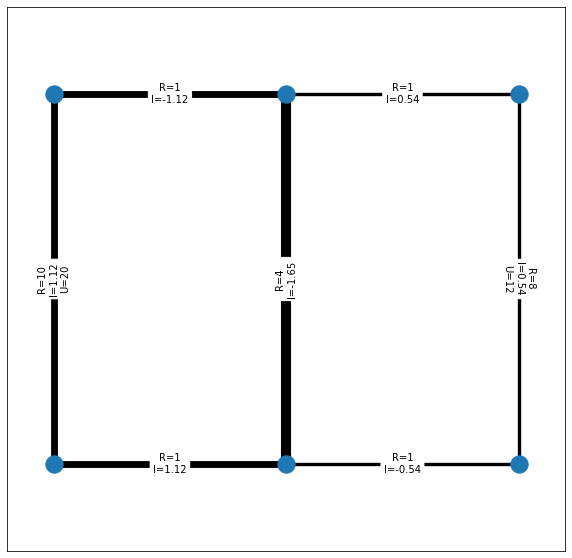

In [18]:
circuit = load_circuit("circuit.txt")
solve_draw(circuit, layout=nx.spectral_layout)

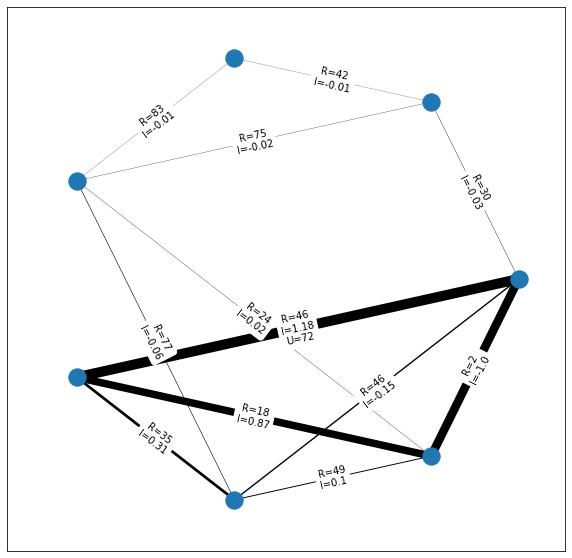

In [19]:
solve_draw(random_circuit(7, p=0.3))

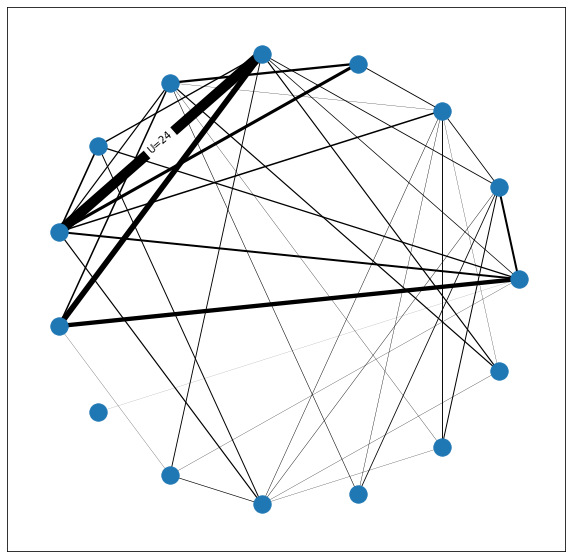

In [20]:
solve_draw(random_circuit(15, p=0.3), partial_labels=True)

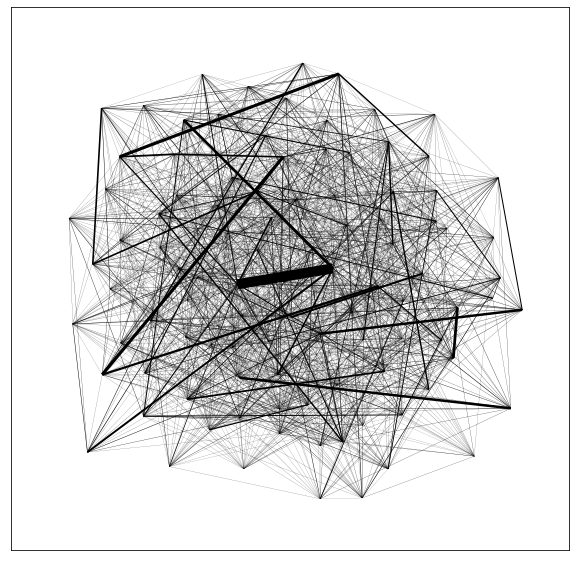

In [21]:
solve_draw(random_circuit(100, p=0.3), with_labels=False, hide_nodes=True, layout=nx.spring_layout)

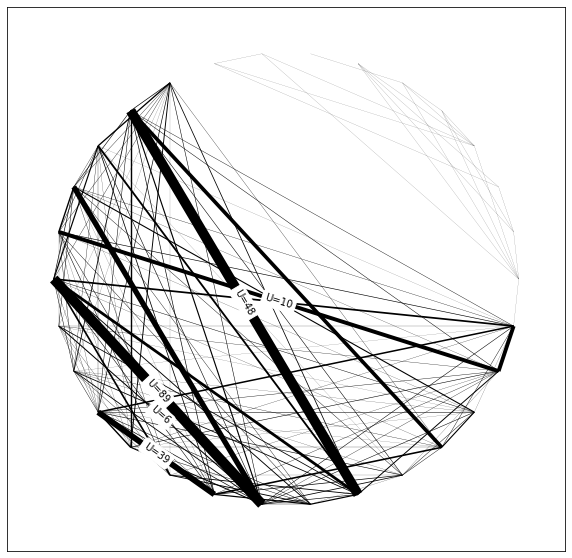

In [22]:
solve_draw(random_circuits([20, 10], 0.6, 0.1), partial_labels=True, hide_nodes=True)

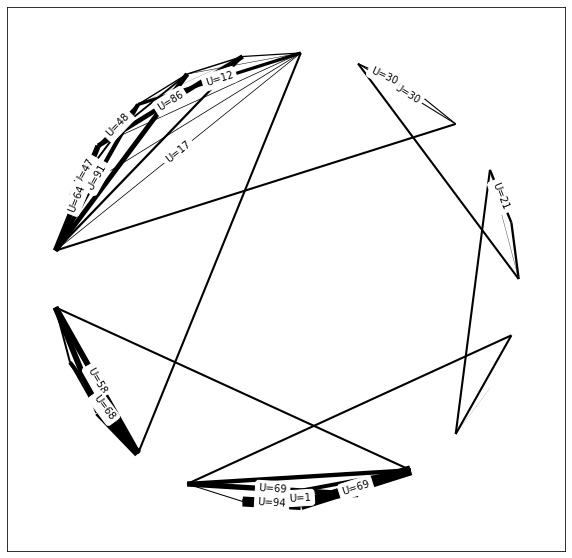

In [23]:
circuit = random_circuits([3, 5, 4, 7, 3, 3], 0.7, p_emf=0.3)
solve_draw(circuit, with_labels=True, test=True, partial_labels=True, hide_nodes=True)

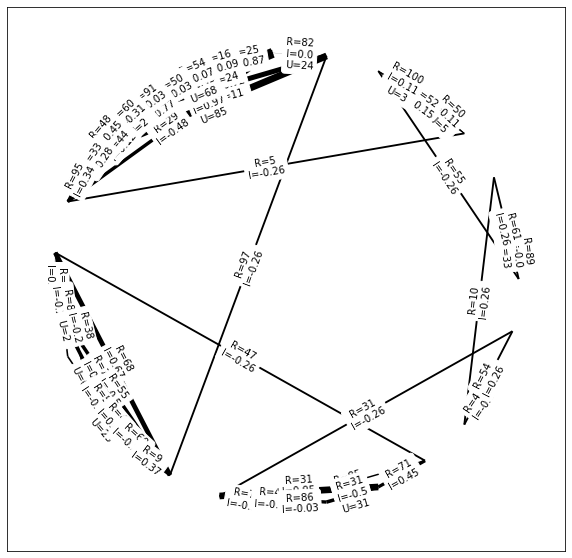

In [24]:
circuit = random_circuits([3, 5, 6, 7, 3, 3], 0.7, p_emf=0.3)
solve_draw(circuit, with_labels=True, test=True, partial_labels=False, hide_nodes=True)

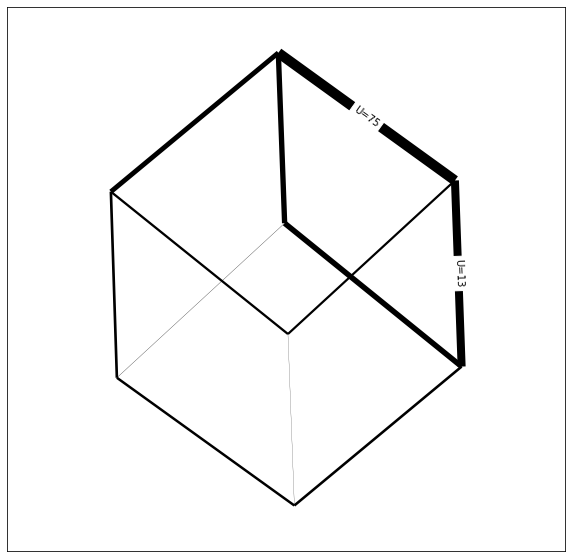

In [25]:
solve_draw(cubical_circuit(p_emf=0.1), with_labels=True, layout=nx.spring_layout, partial_labels=True, hide_nodes=True)

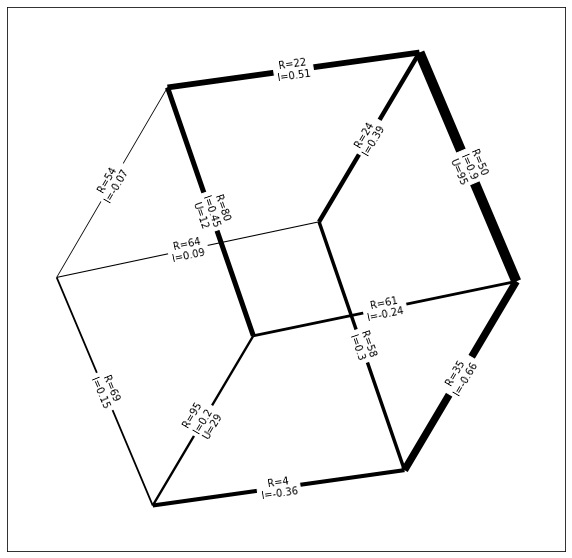

In [26]:
solve_draw(cubical_circuit(p_emf=0.1), with_labels=True, layout=nx.spring_layout, partial_labels=False, hide_nodes=True)

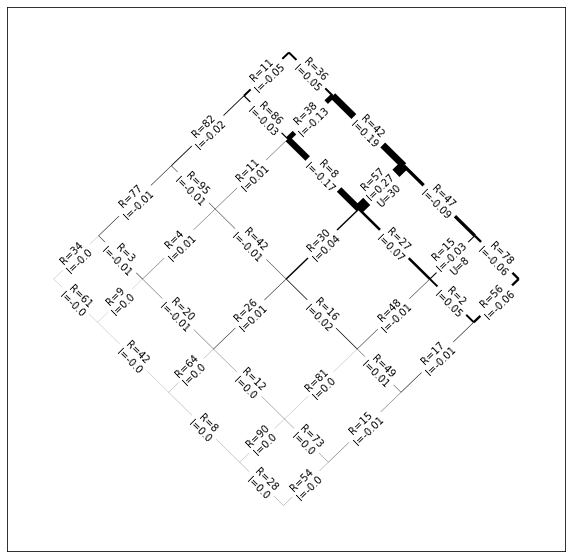

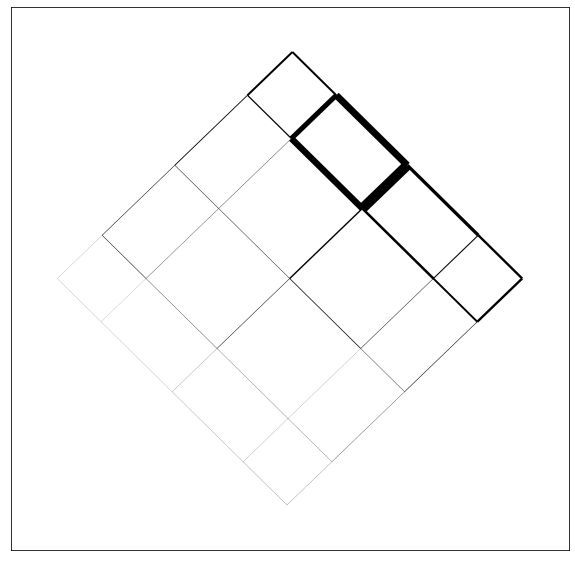

In [27]:
circuit = grid_circuit([5,5])
solve_draw(circuit, with_labels=True, layout=nx.spectral_layout, partial_labels=False, hide_nodes=True)
solve_draw(circuit, with_labels=False, layout=nx.spectral_layout, hide_nodes=True)

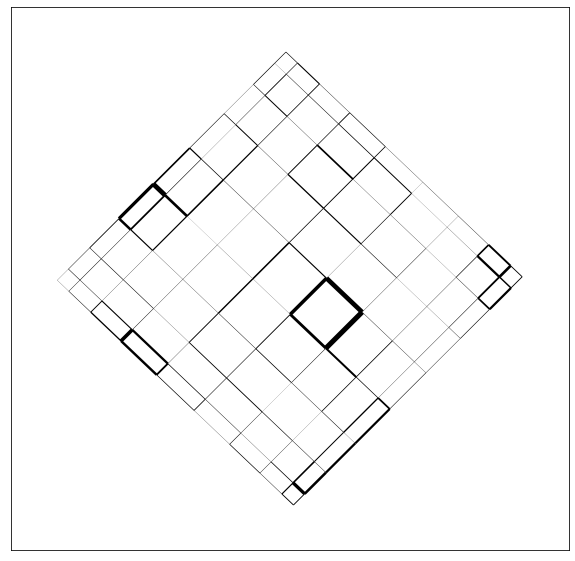

In [70]:
circuit = grid_circuit([10,10])
solve_draw(circuit, with_labels=False, layout=nx.spectral_layout, hide_nodes=True)

Bazując na przedstawionych obwodach można ocenić, że znajdowane rozwiązania są poprawne. Spostrzeżenia przemawiające za poprawnością:
- w przypadku obwodu składającego się z dwóch części połączonych mostkiem zgodnie z oczekiwaniami przez mostek nie płynie prąd. 
- dla obwodu zkładajacego się z większej ilości części połączonych mostkami prąd na każdym mostku jest taki sam.
- test I prawa Kirchoffa został pomyślnie zdany przez każde znalezione rozwiązanie.